# This notebook is copied from treePower.ipynb for parameter testing. 

In [2]:
import platform
import numpy as np
import pandas
from scipy import sparse
from scipy.optimize import broyden1
from functools import partial
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
import scipy
print("Scipy version is", scipy.__version__)

print("System information: ", platform.uname())

Python 3 version is 3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]
Matplotlib version is 3.5.1
Numpy version is 1.22.3
Scipy version is 1.8.0
System information:  uname_result(system='Linux', node='yajun-ThinkPad-T490s', release='5.4.0-131-generic', version='#147-Ubuntu SMP Fri Oct 14 17:07:22 UTC 2022', machine='x86_64', processor='x86_64')


In [3]:
#Define parameters
"""
n_x -- number of grid points, radially; interior points index from 1 to n_x - 1; bdry points are 0 and n_x.
n_t -- number of time steps
plot_at -- grid point at which a temperature curve is drawn
diff_at -- list of two grid points where the temp difference is computed
radius -- radius of tree, m
height -- height of tree, m
thermal_conductivity -- thermal conductivity of the tree, unit W/(mK)
rho -- density of tree trunk, unit kg/m^3
specific_heat -- specific_heat, unit J/(kgK)
albedo -- albedo constant; taken to be 0.3 from Potter Andresen pg.3
sigma -- Stefan–Boltzmann constant, 5.67 × 10 − 8 W ⋅ m − 2 ⋅ K − 4
"""
n_x = 150
n_t = 150
sigma = 5.76e-8
radius = 0.135
thermal_conductivity = 0.16 # Notation Kt in code; k in paper # pg 3-17, wood handbook.
rho = 720
specific_heat = 1300 # table 3-12, at 27 degrees, MC 12% (wood handbook)
albedo = 0.3 # 0.3 is concrete; 0.18, is grass#

time = np.linspace(0, 24, n_t, endpoint = False)
dt = time[1] - time[0]
# Boundary conditions at trunk[0] and trunk[n_x]; Temperature[j] at trunk[j]; in matrix, only index from 1 to n_x-1 (labeled m)
trunk = np.linspace(0, radius, n_x + 1)   
dr = radius / n_x

index1 = int(n_x/3)
index2 = 2 * index1

print("Parameters defined")

Parameters defined


In [4]:
#### Read measured temp data-- only need bark and a mid point for validation

colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

    ##########
coreTemp = dataTemp.s135_3[2:416].tolist() # Oct 21 -- core temp is west, at 13.5cm, at 2m high
coreTempnp = np.asarray([float(t) for t in coreTemp])
coreTempnp = coreTempnp + 273.15
core_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,coreTempnp.size),coreTempnp)
    ##########
    
barkTemp = dataTemp.w_ext_35[2:416].tolist() # Oct 21 -- bark temp is West, at bark, at 3.5m high
barkTempnp = np.asarray([float(v) for v in barkTemp])
barkTempnp = barkTempnp + 273.15
bark_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,barkTempnp.size),barkTempnp)
    
    ##########
midTemp1 = dataTemp.w9_3[2:416].tolist() # Oct 21 -- West, at 9cm, at 3m high
midTemp1np = np.asarray([float(t) for t in midTemp1])
midTemp1np = midTemp1np + 273.15
mid_temp1 = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,midTemp1np.size),midTemp1np)
    ##########
    
midTemp2 = dataTemp.n45_3[2:416].tolist() # Oct 21 -- North, at 4.5cm, at 3m high
midTemp2np = np.asarray([float(t) for t in midTemp2])
midTemp2np = midTemp2np + 273.15
mid_temp2 = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,midTemp2np.size),midTemp2np)
    ##########
    
initTemp = np.array([core_temp[0], mid_temp1[0], mid_temp2[0], bark_temp[0]])
init_temp = np.interp(np.linspace(0,radius,n_x), np.linspace(0,radius,initTemp.size),initTemp)
    ##########
print("testing data read")

testing data read


In [5]:
### Read weather data-- do not need when use measured bark data as outer boundary condition

colnames = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'temperature', 'air_pressure', 'solar_DNI']
dataWeather = pandas.read_excel('Weather_Station_OCT21_to_OCT28_2022.xlsx', names = colnames)
   
temp = dataWeather.temperature[2:145].tolist() # use data from Oct 21
tempnp = np.asarray([float(t) for t in temp])
tempnp = tempnp + 273.15

windspeed = dataWeather.wind_speed[2:145].tolist()
windspeednp = np.asarray([float(v) for v in windspeed])

solar = dataWeather.solar_DNI[2:145].tolist()
solarnp = np.asarray([float(v) for v in solar])

air_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,tempnp.size),tempnp)
wind_speed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,windspeednp.size),windspeednp)
solar_input = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,solarnp.size),solarnp)

print("weather data read")

nu = 15.89e-6 # m^2/s kinematic viscosity of air
Pr = 0.707 
ka = 26.3e-3 # W/mK conductivity of air
coeff = 2 * radius / nu
Re = wind_speed * coeff
C = []
m = []
for j in range(wind_speed.size):
    temp = Re[j]
    if temp < 0.4:
        temp1 = [0, 0] 
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    C.append(temp1[0])
    m.append(temp1[1])
    
Nu = C * Re ** m * Pr ** (1/3)
h = Nu * ka / (2 * radius)
print("heat convection coeff computed")

convect = h * (bark_temp - air_temp)
print("heat convection computed")


sourceTerm = (1 - albedo) * solar_input + sigma * (air_temp**4 - bark_temp**4) + convect

print("source term defined, with size", sourceTerm.size)

weather data read
heat convection coeff computed
heat convection computed
source term defined, with size 150


In [10]:
### test parameters: Kt -- thermal conductivity; rho--density; c -- specific heat

def mol(c = 1.0, Kt = 0.18, rho = 720): #
#     a = rho * c / Kt
    heat_capacity = rho * c
    a = heat_capacity / Kt
    coeffSource = 0 # dt / (2 * heat_capacity * dr)
#     a = 1/8.2e-5# https://en.wikipedia.org/wiki/Thermal_diffusivity# 1/0.005 # thermal diffusivity is 0.005m2/s https://link.springer.com/content/pdf/10.1007/s002260050130.pdf
    a = 357142.85714286
    beta = dt / (a * dr ** 2)
    
    T0 = init_temp # initialize temperature with measured initial condition

    alpha = np.linspace(1, n_x - 1, n_x - 1)# index from 0 to n_x - 2; cor. to points at 1 to n_x - 1
    for j in range(alpha.size):
        alpha[j] = dt / (4 * a * trunk[j + 2] * dr) - 0.5 * beta
        
    
    gamma = np.linspace(1, n_x - 1, n_x - 1)
    for j in range(gamma.size):
        gamma[j] = dt / (4 * a * trunk[j + 1] * dr) + 0.5 * beta
        
    # for the right hand side vector-- gammam is used for Dirichlet at the bark
    
    gammam = dt / (4 * a * trunk[-1] * dr) + 0.5 * beta
    
    # system of Ax_{n+1} = Bx_{n} + v    
    
    # use Neumann condition-- no flux condition
    gamma[0] = beta

    A = sparse.diags([alpha, np.ones(n_x) + beta, -gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    B = sparse.diags([-alpha, np.ones(n_x) - beta, gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    
    T1 = np.zeros((n_x,1))
    
    # soln to include initial temperature
    soln = [T0]
    
    ## time stepping: step1 compute B * T0; step2 rhs = B * T0 + v; step2 solve for T1 with T1 = A^-1 * rhs
    for time in range(n_t - 1):
        rhs = B.dot(T0)
        # with measured bark temperature; plus source term
        rhs[-1] = rhs[-1] + gammam * (bark_temp[time] + bark_temp[time + 1]) + coeffSource * (sourceTerm[time] + sourceTerm[time + 1])
        # with measured air temperature
#         rhs[-1] = rhs[-1] + gammam * (air_temp[time] + air_temp[time + 1])
        T1 = np.linalg.solve(A, rhs) 
        T0 = T1
        
        soln.append(T0) # start saving the solutions from time step 1 
        solnArray = np.array(soln)
        
    return solnArray 
print("function defined")

function defined


## Compute error at: 13.5cm deep, 9cm deep, 4.5cm deep, and bark.

In [6]:
# test cell-- parameter combo -- test case: solution = mol() with default parameter

# K = np.linspace(0.05, 2.0, 196)
# error_Kt = np.zeros((4,196))
# for j in range(196):
#     solution = mol(c = 10, Kt = K[j], rho = 720)
#     temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
#     error_Kt[:,j] = temp

    
# C = np.linspace(10, 3700, 370)
# error_C = np.zeros((4,370))
# for j in range(370):
#     solution = mol(c = C[j], Kt = 1.6, rho = 720)
#     temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
#     error_C[:,j] = temp
    
    
# rho1 = np.linspace(570, 780, 22)
# error_rho = np.zeros((4,22))
# for j in range(22):
#     solution = mol(c = 10, Kt = 1.6, rho = rho1[j])
#     temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
#     error_rho[:,j] = temp
    
# print("parameter testing done")

In [7]:
# print index and the corresponding values of c, Kt, rho

# for j in range(4):
#     print("At the", j, "-th measurement:")
#     dex = np.where(error_Kt[j,:]==np.min(error_Kt[j,:]))[0]
#     print("Kt varies with c = 10, rho = 720", error_Kt[j,:].min())
#     print("Index of smallest error", dex, "Kt=", K[dex])

# for j in range(4):
#     dex = np.where(error_C[j,:]==np.min(error_C[j,:]))[0]
#     print("c varies with Kt = 1.6, rho = 720", error_C[j,:].min())
#     print("Index of smallest error", dex, "c=", C[dex])

# for j in range(4):
#     dex = np.where(error_rho[j,:]==np.min(error_rho[j,:]))[0]
#     print("rho varies with Kt = 1.6, c = 10", error_rho[j,:].min())
#     print("Index of smallest error", dex, "rho=", rho1[dex])



In [8]:
## Try computation with parameters in Potter and Andresen;
"""density rho= 700 kg /m3; specific heat c= 2600 J/(kgK); conductivity Kt = .5 W/(mK); radius r = 0.08m
Result: no improvement with n_x = n_t = 150; 
with n_x = n_t = 1500, solution[:,-2] is better but others no improvement"""
# radius = 0.08
# trunk = np.linspace(0, radius, n_x + 1)   
# dr = radius / n_x

# rho = 700
# c = 2600
# Kt = 0.5

# solution = mol(c, Kt, rho = 700)



'density rho= 700 kg /m3; specific heat c= 2600 J/(kgK); conductivity Kt = .5 W/(mK); radius r = 0.08m\nResult: no improvement with n_x = n_t = 150; \nwith n_x = n_t = 1500, solution[:,-2] is better but others no improvement'

In [9]:
"""compute Kt and c from FireStem2D, and compute temperature with these Kt and c values; GM = specific gravity;
M=moisture content"""
# GM = 0.5 # https://www.wagnermeters.com/specific-gravity/m/
# M = 0.13 # wood handbook, Table 4-2, temp at 21, humidity at 75%

# Kt = GM * (0.1941 + 0.4064 * M) + 0.01864
# print("Thermal conductivity", Kt)

# T = 300 # ~ 300
# cp0 = 0.1031 + 0.00386 * T
# cpw = 3.8 + 130/(645 + T)
# Ac = M * (-0.06191 + 2.36e-4 * T - 1.33e-4)

# cp = (cp0 + cpw * M)/(1+M) + Ac

# print("heat capacity", cp)

# with above cp, and Kt values, run code
# solution = mol(c = 1.57e3, Kt = 0.14, rho = 720)

'compute Kt and c from FireStem2D, and compute temperature with these Kt and c values; GM = specific gravity;\nM=moisture content'

In [7]:
"""a = rho * c/ k; max a at: rho = 700, c = 3000, k = 0.059; min a at : rho = 550, c = 1, k = 1.4"""
amax = 700 * 3000 / 0.059
amin = 500 * 1000 / 1.4

a = np.linspace(amin, amax, 100)
error = np.zeros((4,100))

for j in range(a.size):
    solution = mol(a[j])
    temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
    error[:,j] = temp
    
print("parameter testing is done")    

parameter testing is done


In [9]:
for j in range(4):
    print("At the", j, "-th measurement:")
    dex = np.where(error[j,:]==np.min(error[j,:]))[0]
    print("rho * c /kt varies with smallest error:", error[j,:].min())
    print("Index of smallest error", dex, "a=", a[dex])

At the 0 -th measurement:
rho * c /kt varies with smallest error: 1.500000415641182
Index of smallest error [99] a= [35593220.33898305]
At the 1 -th measurement:
rho * c /kt varies with smallest error: 1.4248881174194707
Index of smallest error [0] a= [357142.85714286]
At the 2 -th measurement:
rho * c /kt varies with smallest error: 1.790778010273982
Index of smallest error [0] a= [357142.85714286]
At the 3 -th measurement:
rho * c /kt varies with smallest error: 2.7938063857608313
Index of smallest error [0] a= [357142.85714286]


In [11]:
solution = mol(c = 1000, Kt = 1.8, rho = 500)

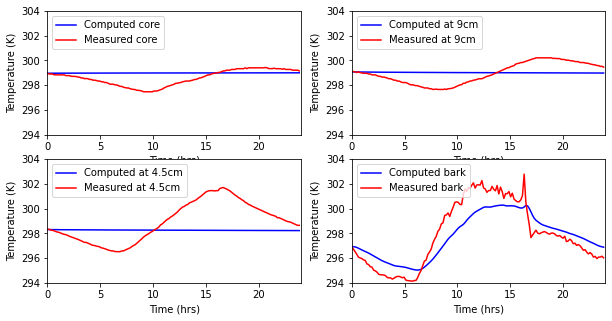

In [12]:
# visualize

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

ax[0,0].plot(time, solution[:,0], 'b-', label='Computed core')
ax[0,0].plot(time, core_temp, 'r-', label='Measured core')
ax[0,0].legend(loc="upper left")
ax[0,0].axis([0, 24, 294, 304])
ax[0,0].set_xlabel('Time (hrs)')
ax[0,0].set_ylabel('Temperature (K)')


ax[0,1].plot(time, solution[:,index1], 'b-', label='Computed at 9cm')
ax[0,1].plot(time, mid_temp1, 'r-', label='Measured at 9cm')
ax[0,1].legend(loc="upper left")
ax[0,1].axis([0, 24, 294, 304])
ax[0,1].set_xlabel('Time (hrs)')
ax[0,1].set_ylabel('Temperature (K)')

ax[1,0].plot(time, solution[:,index2], 'b-', label='Computed at 4.5cm')
ax[1,0].plot(time, mid_temp2, 'r-', label='Measured at 4.5cm')
ax[1,0].legend(loc="upper left")
ax[1,0].axis([0, 24, 294, 304])
ax[1,0].set_xlabel('Time (hrs)')
ax[1,0].set_ylabel('Temperature (K)')


ax[1,1].plot(time, solution[:,-2], 'b-', label='Computed bark')
ax[1,1].plot(time, bark_temp, 'r-', label='Measured bark')
ax[1,1].legend(loc="upper left")
ax[1,1].axis([0, 24, 294, 304])
ax[1,1].set_xlabel('Time (hrs)')
ax[1,1].set_ylabel('Temperature (K)')

plt.show()

